In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options  


In [2]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--no-sandbox")

driver = webdriver.Chrome('chromedriver', options=chrome_options)

### Extract date



In [3]:
url = 'https://www.moh.gov.sg/2019-ncov-wuhan'

driver.get(url)
content = driver.page_source


In [4]:
soup =BeautifulSoup(content, 'lxml')

In [5]:
data = soup.findAll(text=re.compile("Case Summary in Singapore \(as of .+"))


In [6]:
data

['Case Summary in Singapore (as of 27 Feb 2020, 1200h)']

In [7]:
m = re.search("(\d\d \w+ 202\d, \d+\d+h)", data[0])
date_time_str = m.group(1)
data_date_time = datetime.strptime(date_time_str, '%d %b %Y, %H%Mh').strftime('%Y-%m-%d')
data_date_time


'2020-02-27'

### Extract Dataframes

In [8]:
dfs = pd.read_html(content)

In [9]:
dfs

[    0   1
 0 NaN NaN
 1 NaN NaN,     0   1
 0 NaN NaN
 1 NaN NaN,                        0   1
 0           Hospitalised  30
 1             Discharged  66
 2  Total Confirmed Cases  96,                0       1
 0  DORSCON Level  Orange,               0                                                  1
 0          Date                                              Title
 1   28 Feb 2020  General advisory for employers if a confirmed ...
 2   27 Feb 2020  General Advisory for Workplace Measures in Res...
 3   27 Feb 2020  Advisory for Employers and Employees Travellin...
 4   27 Feb 2020  General Advisory for Workplaces and Frontline ...
 5   27 Feb 2020  One-Day Suspension of Classes and Activities a...
 6   27 Feb 2020  Four More Cases Discharged; Three New Cases of...
 7   26 Feb 2020  Four More Cases Discharged; Two New Cases of C...
 8   26 Feb 2020  Singapore Permanent Resident Breached Stay-Hom...
 9   26 Feb 2020  Two charged under Infectious Diseases Act for ...
 10  26 Feb 20

In [10]:
# Look for df with confirmed cases, tested negative, ...

for df in dfs:
    combined_fields = df[0].to_string().lower()
    if "confirmed cases" in combined_fields and "discharged" in combined_fields:
        sing_cases_df = df
        
sing_cases_df

,0,1
0,Hospitalised,30
1,Discharged,66
2,Total Confirmed Cases,96


In [11]:
# cleanup to make sure they are numbers

sing_cases_df[1] = sing_cases_df[1].apply(lambda x: re.sub(r'[^\d]+', '', str(x)))
sing_cases_df

,0,1
0,Hospitalised,30
1,Discharged,66
2,Total Confirmed Cases,96


In [12]:

# flip the table around
sing_cases_df = sing_cases_df.set_index(0).T

sing_cases_df

,Hospitalised,Discharged,Total Confirmed Cases
1,30,66,96


In [13]:
# column name mapping
old_new_map= {'confirmed': 'confirmed', 
           'negative': 'negative',
           'pending': 'pending',
           'hospitalised':'hospitalised',
           'discharged':'discharged'}
def map_name(old_name):
    for k,v in old_new_map.items():
        if k in old_name.lower():
            return v
    return None
    
sing_cases_df.columns = sing_cases_df.columns.map(map_name)
sing_cases_df.insert(0, 'datetime', data_date_time)

df = sing_cases_df
df

,datetime,hospitalised,discharged,confirmed
1,2020-02-27,30,66,96


### Save to file

In [14]:
from pathlib import Path
csv_file = 'data/singapore-cases.csv'

if Path(csv_file).exists():
    # read out the old data
    old_df = pd.read_csv(csv_file)
    df = df.set_index('datetime').append(old_df.set_index('datetime'))



/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [15]:
df = df.reset_index()
df.drop_duplicates(subset=['datetime'], inplace=True)

In [16]:
df.sort_values(by=['datetime'], inplace=True)
df

,datetime,confirmed,discharged,hospitalised,negative,pending
1,2020-02-02,18,NaN,NaN,240.0,43.0
2,2020-02-03,24,NaN,NaN,262.0,32.0
3,2020-02-04,24,NaN,NaN,289.0,20.0
4,2020-02-05,28,NaN,NaN,295.0,62.0
5,2020-02-06,33,NaN,NaN,310.0,147.0
6,2020-02-07,33,NaN,NaN,363.0,181.0
7,2020-02-08,40,NaN,NaN,438.0,181.0
8,2020-02-09,45,7,NaN,581.0,39.0
9,2020-02-10,45,7,NaN,581.0,39.0
10,2020-02-11,47,9,NaN,608.0,43.0


In [17]:
df.to_csv(csv_file, index=False)


### Plot graph

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

png_file = 'images/singapore-cases.png'
# convert to pd.datetime
df['datetime_idx'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d")

df.set_index('datetime_idx', inplace=True)



In [19]:
df

,datetime,confirmed,discharged,hospitalised,negative,pending
datetime_idx,,,,,,
2020-02-02,2020-02-02,18,NaN,NaN,240.0,43.0
2020-02-03,2020-02-03,24,NaN,NaN,262.0,32.0
2020-02-04,2020-02-04,24,NaN,NaN,289.0,20.0
2020-02-05,2020-02-05,28,NaN,NaN,295.0,62.0
2020-02-06,2020-02-06,33,NaN,NaN,310.0,147.0
2020-02-07,2020-02-07,33,NaN,NaN,363.0,181.0
2020-02-08,2020-02-08,40,NaN,NaN,438.0,181.0
2020-02-09,2020-02-09,45,7,NaN,581.0,39.0
2020-02-10,2020-02-10,45,7,NaN,581.0,39.0


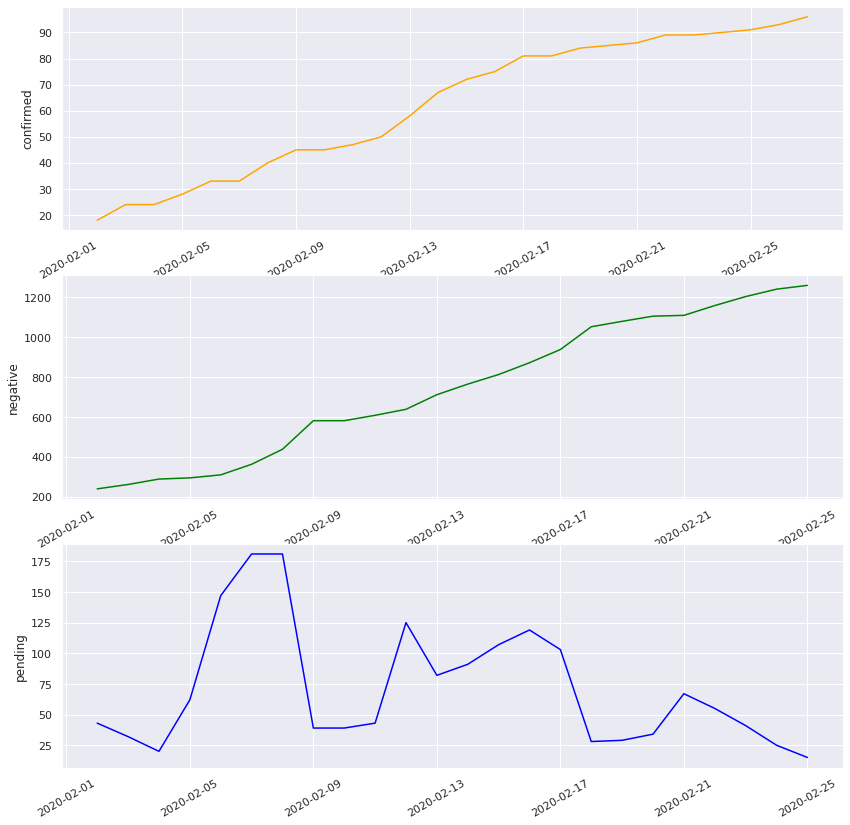

In [20]:
sns.set(rc={'figure.figsize':(14,14)})

fig, axs = plt.subplots(nrows=3)

sns.lineplot(x=df.index, y = 'confirmed', data=df, ax= axs[0], estimator=None, color='orange')
sns.lineplot(x=df.index, y = 'negative', data=df, ax= axs[1], estimator=None, color='green')
sns.lineplot(x=df.index, y = 'pending', data=df, ax= axs[2], estimator=None, color='blue')

for ax in axs:
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation=30)



In [21]:
fig.savefig(png_file)